# utils 

In [2]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [5]:
def plot_data(X, y):
    # Create New Figure
    fig = plt.figure()

    plt.plot(X[y==0, 0], X[y==0, 1], 'k*')
    plt.plot(X[y==1, 0], X[y==1, 1], 'ko', mfc='yellow')
    
    
def mapFeature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.

    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.

    degree: int, optional
        The polynomial degree.

    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)
    
    
def plotDecisionBoundary(plot_func, theta, X, y):
    """
    Plots the data points X and y into a new figure with the decision boundary defined by theta.
    Plots the data points with * for the positive examples and o for  the negative examples.

    Parameters
    ----------
    plot_func : func
        A function reference for plotting the X, y data.

    theta : array_like
        Parameters for logistic regression. A vector of shape (n+1, ).

    X : array_like
        The input dataset. X is assumed to be  a either:
            1) Mx3 matrix, where the first column is an all ones column for the intercept.
            2) MxN, N>3 matrix, where the first column is all ones.

    y : array_like
        Vector of data labels of shape (m, ).
    """
    # make sure theta is a numpy array
    theta = np.array(theta)

    # Plot Data (remember first column in X is the intercept)
    plot_func(X[:, 1:3], y)

    if X.shape[1] <= 3:
        # Only need 2 points to define a line, so choose two endpoints
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calculate the decision boundary line
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        # Plot, and adjust axes for better viewing
        plt.plot(plot_x, plot_y)

        # Legend, specific for the exercise
        plt.legend(['Admitted', 'Not admitted', 'Decision Boundary'])
        plt.xlim([30, 100])
        plt.ylim([30, 100])
    else:
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        # Evaluate z = theta*x over the grid
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  # important to transpose z before calling contour
        # print(z)

        # Plot z = 0
        plt.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)

# Логистическая регрессия

## Загрузка данных

In [47]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt(os.path.join('Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

## Визуализация данных

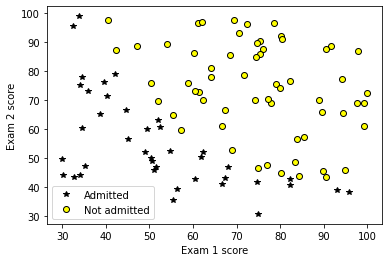

In [4]:
plot_data(X, y)
# add axes labels
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not admitted'])

## Реализация

### Сигмоида

Вспоминая из лекции:

$$ a_w(x) = \sigma(w^T x)$$

где $\sigma$ -- сигмоида, которая определяется следующим образом: 

$$\sigma(z) = \frac{1}{1+e^{-z}}.$$

Для начала реализуем функцию сигмоиды самостоятельно.

Для проверки: для больших положительных $x$ значение должны быть близкое к 1, для больших отрицательных $x$ близкое к 0, $\sigma(0)=0.5.$

In [15]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)
    
    # You need to return the following variables correctly 
    g = np.zeros(z.shape)  
    return 1. / (1 + np.exp(-z))

Проверим, что у нас все получилось правильно.

In [6]:
# Test the implementation of sigmoid function here
z = 0
s = sigmoid(z)

print('s(', z, ') = ', s)

s( 0 ) =  0.5


###  Функция потерь и градиент

Реализуем лосс-функцию и ее градиент. Перед этим добавим константный признак.

In [48]:
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Вспомним как выглядит функция потерь для логистической регрессии.

$$ L(w) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(a_w\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - a_w\left( x^{(i)} \right) \right) \right]$$

Градиент, соотвественно, будет иметь вид:

$$ \frac{\partial L(w)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \left( a_w \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Видим, что формула выглядит так же как и для линейной регрессии, но у нас здесь разные $a_w(x)$.

In [54]:
def costFunction(w, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    w : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    L : float
        The computed value for the cost function. 
    
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to w, at the current values of w.
        
    Instructions
    ------------
    Compute the cost of a particular choice of w. You should set L to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in w.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    L = 0
    grad = np.zeros(w.shape)
    
    # cost
    a = sigmoid(X @ w)
    term1 = y * np.log(a)
    term2 = (1. - y) * np.log(1. - a)
    L = -np.sum(term1 + term2) / m
    # gradient
    grad = np.dot((a - y), X) / m    
#     grad = np.mean(X.dot(a - y))
    return L, grad

Проверка.

In [55]:
# Initialize fitting parameters
initial_w = np.zeros(n+1)

cost, grad = costFunction(initial_w, X, y)

print('Cost at initial w (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial w (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Compute and display cost and gradient with non-zero w
test_w = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_w, X, y)

print('Cost at test w: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test w:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')

Cost at initial w (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial w (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test w: 0.218
Expected cost (approx): 0.218

Gradient at test w:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


### `scipy.optimize`

До этого мы реализовали метод для вычиселния функции потерь и ее градиента, теперь мы попробуем вычислить ее минимум с помощью [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html).
SciPy это библиотека с вычислительными методами на `python`. Ее модуль оптимизации позволяет находить корни и экстремумы.

Итак, для логистической регрессии мы хотим оптимизировать $L(w)$ по параметру $w$.
Для этого методу `optimize.minimize` подадим на вход следующие параметры:
- `costFunction`: лосс-функция.
- `initial_w`: начальное значения для вектора весов.
- `(X, y)`: допольнительные аргументы для функции потерь.
- `jac`: индикатор того, что наша ф-ия потерь возвращает Якобиан (градиент) вместе со значением самой ф-ии.
- `method`: метод, который будет использоваться для оптимизации.
- `options`: дополнительные параметры, которые может использовать метод оптимизации, например, ограничение на кол-во итераций.

In [56]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
res = optimize.minimize(costFunction,
                        initial_w,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized w
cost = res.fun

# the optimized w is in the x property
w = res.x

# Print theta to screen
print('Cost at w found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n');

print('w:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*w))
print('Expected w (approx):\n\t[-25.161, 0.206, 0.201]')

Cost at w found by optimize.minimize: 0.203
Expected cost (approx): 0.203

w:
	[-25.161, 0.206, 0.201]
Expected w (approx):
	[-25.161, 0.206, 0.201]


После успешного вычисления оптимального $w$, мы можем построить нашу разделяющую плоскость.
ДОБАВИТЬ ФОРМУЛУ

<!-- ![](Figures/decision_boundary1.png) -->


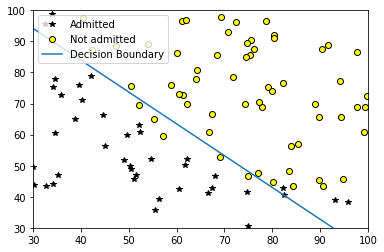

In [57]:
# Plot Boundary
plotDecisionBoundary(plot_data, w, X, y)

### Предсказание логистической регрессии

На данный момент мы умеем минимизировать нашу функцию потерь на обучающей выборке, но этого мало, тк мы хотим для объектов из тестовой выборки получать метку класса 0 или 1 на выходе алгоритма.

In [58]:
def predict(w, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(w.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    w : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)
    p = sigmoid(X@w) >= 0.5
    return p

In [59]:
#  Predict probability for a student with score 45 on exam 1 
#  and score 85 on exam 2 
prob = sigmoid(np.dot([1, 45, 85], w))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))
print('Expected value: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(w, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))
print('Expected accuracy (approx): 89.00 %')

For a student with scores 45 and 85,we predict an admission probability of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.00 %
Expected accuracy (approx): 89.00 %


##  Регуляризация

В этой части мы реализуем алгоритм логистической регресии с регуляризацией на данных о качестве произведенных микрочипов.
По результатам двух тестов мы хотим принять решение о дальнейшей судьбе изделия (брак или нет).

In [174]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt('ex2data2.txt', delimiter=',')
X = data[:, :2]
y = data[:, 2]

### Визуализация

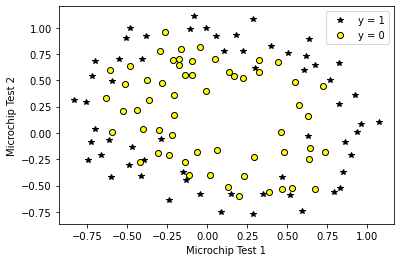

In [165]:
plot_data(X, y)
# Labels and Legend
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

# Specified in plot order
plt.legend(['y = 1', 'y = 0'], loc='upper right')

На графике видно, что провести линию будет недостаточно для решения этой задачи.

### Нелинейные признаки

Один из способов добавления нелинейности -- комбинации признаков. Для этого мы будем использовать метод `mapFeature`. Посчитаем комбинации до 6 степени.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

Такая степень позволит логистической регрессии посторить более сложную разделяющую поверхность, но у нас есть большие шансы переобучиться.

In [182]:
# Note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6)
X = poly.fit_transform(X)

### Функция потерь и градиент

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.
Далее необходимо реализовать метод `costFunctionReg` для логиистической регрессии с регуляризацией.

Функция потерь будет выглядеть следующим образом:

$$ L(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( a_w \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - a_w \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2 $$

Помним, что мы не накладываем ограничение на $w_0$. Градиент будет выглядеть так:
Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial L(w)}{\partial w_0} = \frac{1}{m} \sum_{i=1}^m \left( a_w \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial L(w)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( a_w \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}w_j \qquad \text{for } j \ge 1 $$

In [183]:
def costFunctionReg(w, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    w : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    L : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to w, at the current values of w.
    
    Instructions
    ------------
    Compute the cost `L` of a particular choice of w.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in w.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    L = 0
    grad = np.zeros(w.shape)
    
    a = sigmoid(X @ w)
    term1 = np.log(a).T @ y
    term2 = np.log(1. - a).T @ (1. - y)
    
    wss = np.sum(w[1:] ** 2)
    reg_coef = lambda_ * wss / (2 * m)
    
    L = (1 / m) * (-term1 - term2) + reg_coef
    
    grad = (1 / m) * X.T @ (a - y) + (lambda_ / m) * np.concatenate((np.array([0]), w[1:]))
    
    return L, grad

Once you are done with the `costFunctionReg`, we call it below using the initial value of $\theta$ (initialized to all zeros), and also another test case where $\theta$ is all ones.

In [184]:
# Initialize fitting parameters
initial_w = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_w, X, y, lambda_)

print('Cost at initial w (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial w (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_w = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_w, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at test theta - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Cost at initial w (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial w (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at test theta - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


###  `scipy.optimize.minimize`

Аналогично можно использовать `optimize.minimize` для поиска $w$.

### Пример

In this part of the exercise, you will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting.

Notice the changes in the decision boundary as you vary $\lambda$. With a small
$\lambda$, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. See the following figures for the decision boundaries you should get for different values of $\lambda$. 

<table>
    <tr>
        <td style="text-align:center">
            No regularization (overfitting)<img src="Figures/decision_boundary3.png">
        </td>        
        <td style="text-align:center">
            Decision boundary with regularization
            <img src="Figures/decision_boundary2.png">
        </td>
        <td style="text-align:center">
            Decision boundary with too much regularization
            <img src="Figures/decision_boundary4.png">
        </td>        
    <tr>
</table>

This is not a good decision boundary: for example, it predicts that a point at $x = (−0.25, 1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.
With a larger $\lambda$, you should see a plot that shows an simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set to too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

C:\Users\Admin\AppData\Local\Temp\ipykernel_8840\1221610780.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(out)


Train Accuracy: 86.4 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



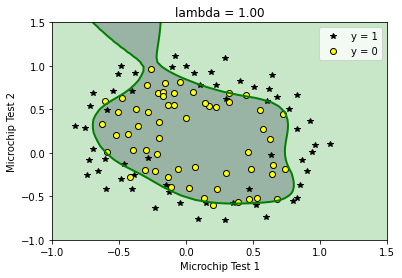

In [66]:
# Initialize fitting parameters
initial_w = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunction,
                        initial_w,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
w = res.x

plotDecisionBoundary(plot_data, w, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Compute accuracy on our training set
p = predict(w, X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))
print('Expected accuracy (with lambda = 1): 83.1 % (approx)\n')

# sklearn 

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [73]:
X.shape, y.sum()

((118, 28), 58.0)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [71]:
X_train.shape, X_test.shape

((94, 28), (24, 28))

In [72]:
y_train.sum() / y_train.shape[0], y_test.sum() / y_test.shape[0]

(0.48936170212765956, 0.5)

In [76]:
m = LogisticRegression(fit_intercept=False, random_state=0, n_jobs=2)

In [77]:
m.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, n_jobs=2, random_state=0)

In [78]:
accuracy_score(y_train, m.predict(X_train)), \
accuracy_score(y_test, m.predict(X_test))

(0.8085106382978723, 0.875)